In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
plt.style.use('paper.mplstyle')
sys.path.append('../spock/')
#from simsetup import get_sim
#from modelfitting import ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

%matplotlib inline


In [2]:
datasetold = pd.read_csv('../modeldata/AllFeatLongera.csv')
datasetnew = pd.read_csv('../modeldata/AFixedPairsAll.csv')
resRemove =  pd.read_csv('../../cleanData/csvs/resonant/removeLables.csv')
randRemove =  pd.read_csv('../../cleanData/csvs/random/removeLables.csv')
randRemove=randRemove.drop('Unnamed: 0',axis=1)
remove = pd.concat([resRemove,randRemove])


In [3]:
def hasnull(row):
    numnulls = row.isnull().sum()
    if numnulls == 0:
        return 0
    else:
        return 1

def tmax(row):
    #sim = get_sim(row, csvfolder)
    tmax = 1e4 # replace with a calculation of tmax
    return tmax

In [4]:
def getData(dataset,remove):    
    dataset = dataset.drop('logInstT3BR', axis=1)
    dataset = dataset.drop('3Bfirstfillfac', axis=1)
    
    
    dataset['log']= np.log10(dataset['ThetaSTD']/1.8)
    dataset = datasetold.join(remove)
    dataset = dataset[25000:]
    dataset = dataset.drop(dataset[dataset['remove']==True].index)
    scrambled = dataset
    print(scrambled.shape[0])

    scrambled['fail3BR']=scrambled['threeBRfillfac']>1
    scrambled['z12']=scrambled['IntZval12']/scrambled['Zcrit12']
    scrambled['z23']=scrambled['IntZval23']/scrambled['Zcrit23']
    scrambled['Zfail']= (scrambled['z12']>1) | (scrambled['z23']>1)
    scrambled['passBoth']= (scrambled['Zfail']==False) & (scrambled['fail3BR']==False)
    #break into train and test
    Nrows = int(0.8*scrambled.shape[0])
    train = scrambled.iloc[:Nrows, :]
    test = scrambled.iloc[Nrows:, :]
    test =test.drop(test[test['prelimStable']==False].index)
    return train,test

In [5]:
IntDat = ['threeBRfillfac','log','Zcrit12','Zcrit23','IntZval12','IntZval23','MEGNO','EMcrossnear','EMcrossfar','EMcrossouter','MMRstrengthnear','MMRstrengthfar']
Dat = ['threeBRfillfac','log','Zcrit12','Zcrit23','Zval12','Zval23','MEGNO','EMcrossnear','EMcrossfar','EMcrossouter','MMRstrengthnear','MMRstrengthfar']
all = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear',
       'twoMMRstrengthnear', 'MMRstrengthWnear', 'MMRstrengthWMAXnear',
       'twoMMRstrengthWnear', 'twoMMRstrengthWMAXnear', 'EMcrossfar',
       'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar', 'twoMMRstrengthfar',
       'MMRstrengthWfar', 'MMRstrengthWMAXfar', 'twoMMRstrengthWfar',
       'twoMMRstrengthWMAXfar', 'EMcrossouter', 'EMfracstdouter', 'EPstdouter',
       'MMRstrengthouter', 'twoMMRstrengthouter', 'MMRstrengthWouter',
       'MMRstrengthWMAXouter', 'twoMMRstrengthWouter',
       'twoMMRstrengthWMAXouter', 'MEGNO', 'MEGNOstd', 'threeBRfillfac',
       'threeBRfillstd', 'chiSec', 'ThetaSTD', 'p2/1', 'p3/2', 'Zval12',
       'Zcrit12', 'Zval23', 'Zcrit23', 'IntZval12', 'IntZval23','z12','z23']

In [6]:
oldtrain, oldtest = getData(datasetold,remove)
newtrain, newtest = getData(datasetnew,remove)

126878
126878


In [7]:
#features var covers all features
oldresultBalance = oldtrain['Stable'].value_counts()[False]/oldtrain['Stable'].value_counts()[True]

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, confusion_matrix, auc
import sklearn

In [9]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno

In [10]:
spock = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 10,
                         n_estimators = 125,
                         scale_pos_weight=oldresultBalance)

In [11]:
spock.fit(oldtrain[features], oldtrain["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=125, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [12]:
def ROC_curve( model, x,y):
    preds = model.predict_proba(x)[:,1]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    roc_auc = sklearn.metrics.roc_auc_score(y, preds)
    return roc_auc, fpr, tpr, ROCthresholds

Text(0.5, 1.0, 'ROC curve (AUC = 0.949)')

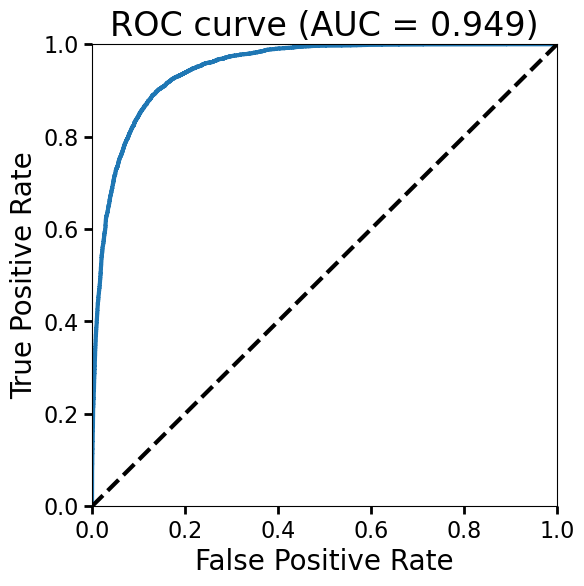

In [13]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(spock, oldtest[features], oldtest['Stable'])

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [14]:
testFail = oldtest.drop(oldtest[oldtest['passBoth']==False].index)
testFail.drop(testFail[testFail['prelimStable']==False].index)

,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,MMRstrengthWMAXnear,twoMMRstrengthWnear,twoMMRstrengthWMAXnear,...,instability_time,shadow_instability_time,Unnamed: 0,runstring,remove,fail3BR,z12,z23,Zfail,passBoth
113092,113092,0.076745,0.029328,0.000389,0.073538,0.006633,0.000300,0.000462,0.001009,0.001267,...,2.937670e+07,4.674212e+06,113092.0,8921642.bin,False,False,0.063635,0.354673,False,True
113093,113093,0.126751,0.088763,0.001128,0.038164,0.004531,0.002155,0.002801,0.002095,0.002723,...,7.900263e+07,3.112127e+08,113093.0,8922250.bin,False,False,0.712784,0.056846,False,True
113095,113095,0.143203,0.029496,0.000327,0.689647,0.014204,0.002624,0.002781,0.004246,0.004474,...,1.000000e+09,1.000000e+09,113095.0,8922253.bin,False,False,0.733294,0.235816,False,True
113099,113099,0.081747,0.041247,0.000696,0.237445,0.005910,0.001905,0.002411,0.001916,0.002449,...,4.139601e+05,2.292913e+05,113099.0,8922258.bin,False,False,0.638503,0.499547,False,True
113103,113103,0.311240,0.067352,0.005347,1.754665,0.000000,0.012623,0.015188,0.000000,0.000000,...,1.000000e+09,1.000000e+09,113103.0,8922876.bin,False,False,0.552164,0.497321,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138519,138519,0.183145,0.017872,0.003883,0.067773,0.015923,0.001768,0.002905,0.006314,0.008123,...,9.720290e+07,6.887756e+07,NaN,NaN,NaN,False,0.773586,0.406791,False,True
138523,138523,0.077014,0.013032,0.001116,0.070067,0.005255,0.000186,0.000277,0.000806,0.000984,...,1.180864e+08,5.212156e+07,NaN,NaN,NaN,False,0.314212,0.153057,False,True
138527,138527,0.182237,0.006964,0.004026,0.255735,0.006920,0.001088,0.001223,0.002719,0.002979,...,2.241490e+07,2.655603e+07,NaN,NaN,NaN,False,0.321069,0.271378,False,True
138534,138534,0.125097,0.038105,0.003736,0.026522,0.004762,0.002118,0.003164,0.002059,0.003076,...,1.131076e+06,9.600385e+05,NaN,NaN,NaN,False,0.365208,0.387514,False,True


Text(0.5, 1.0, 'ROC curve (AUC = 0.918)')

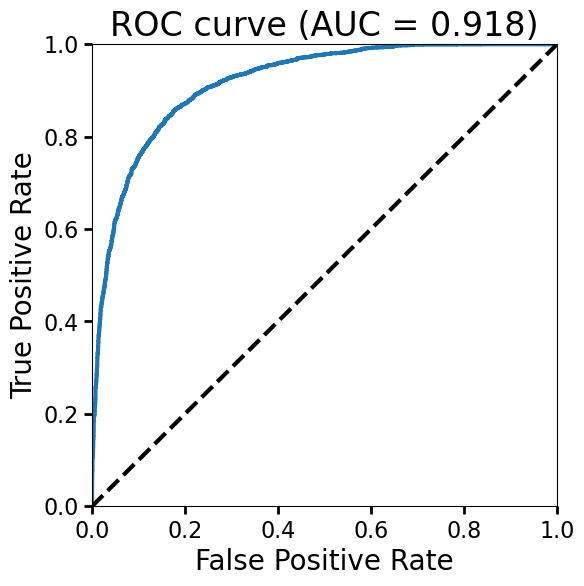

In [16]:

oroc_auc, ofpr, otpr, oROCthresholds = ROC_curve(spock, testFail[features], testFail['Stable'])

fig, ax = plt.subplots()
ax.plot(ofpr, otpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(oroc_auc))

In [17]:
trainF = newtrain.drop(newtrain[newtrain['passBoth']==False].index)

In [18]:
resultBalanceF = trainF['Stable'].value_counts()[False]/trainF['Stable'].value_counts()[True]

In [19]:
spockF = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 35, 
                         subsample = 0.9,
                         min_child_weight = 5,
                         n_estimators = 400,
                         scale_pos_weight=resultBalanceF)

In [20]:
spockF.fit(trainF[all], trainF["Stable"])


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=35, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [21]:
ntestFail = newtest.drop(newtest[newtest['passBoth']==False].index)
ntestFail.drop(testFail[testFail['prelimStable']==False].index)

,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,MMRstrengthWMAXnear,twoMMRstrengthWnear,twoMMRstrengthWMAXnear,...,instability_time,shadow_instability_time,Unnamed: 0,runstring,remove,fail3BR,z12,z23,Zfail,passBoth
113092,113092,0.076745,0.029328,0.000389,0.073538,0.006633,0.000300,0.000462,0.001009,0.001267,...,2.937670e+07,4.674212e+06,113092.0,8921642.bin,False,False,0.063635,0.354673,False,True
113093,113093,0.126751,0.088763,0.001128,0.038164,0.004531,0.002155,0.002801,0.002095,0.002723,...,7.900263e+07,3.112127e+08,113093.0,8922250.bin,False,False,0.712784,0.056846,False,True
113095,113095,0.143203,0.029496,0.000327,0.689647,0.014204,0.002624,0.002781,0.004246,0.004474,...,1.000000e+09,1.000000e+09,113095.0,8922253.bin,False,False,0.733294,0.235816,False,True
113099,113099,0.081747,0.041247,0.000696,0.237445,0.005910,0.001905,0.002411,0.001916,0.002449,...,4.139601e+05,2.292913e+05,113099.0,8922258.bin,False,False,0.638503,0.499547,False,True
113103,113103,0.311240,0.067352,0.005347,1.754665,0.000000,0.012623,0.015188,0.000000,0.000000,...,1.000000e+09,1.000000e+09,113103.0,8922876.bin,False,False,0.552164,0.497321,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138519,138519,0.183145,0.017872,0.003883,0.067773,0.015923,0.001768,0.002905,0.006314,0.008123,...,9.720290e+07,6.887756e+07,NaN,NaN,NaN,False,0.773586,0.406791,False,True
138523,138523,0.077014,0.013032,0.001116,0.070067,0.005255,0.000186,0.000277,0.000806,0.000984,...,1.180864e+08,5.212156e+07,NaN,NaN,NaN,False,0.314212,0.153057,False,True
138527,138527,0.182237,0.006964,0.004026,0.255735,0.006920,0.001088,0.001223,0.002719,0.002979,...,2.241490e+07,2.655603e+07,NaN,NaN,NaN,False,0.321069,0.271378,False,True
138534,138534,0.125097,0.038105,0.003736,0.026522,0.004762,0.002118,0.003164,0.002059,0.003076,...,1.131076e+06,9.600385e+05,NaN,NaN,NaN,False,0.365208,0.387514,False,True


Text(0, 0.5, 'True Positive Rate')

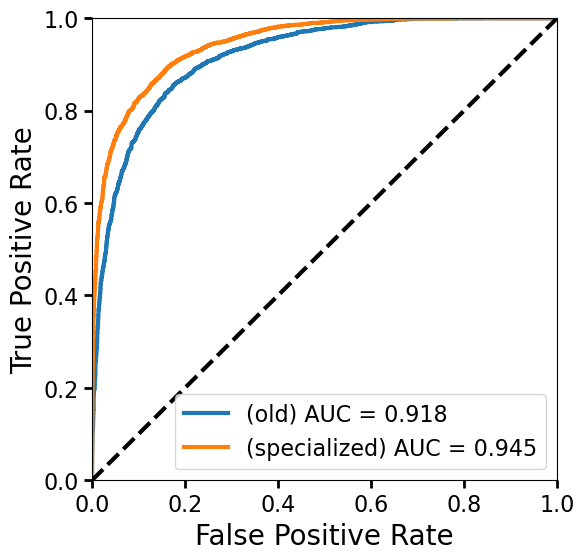

In [22]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(spockF, ntestFail[all], ntestFail['Stable'])
oroc_auc, ofpr, otpr, oROCthresholds = ROC_curve(spock, testFail[features], testFail['Stable'])


fig, ax = plt.subplots()
ax.plot(ofpr, otpr, label='(old) AUC = {0:.3f}'.format(oroc_auc))

ax.plot(fpr, tpr,label='(specialized) AUC = {0:.3f}'.format(roc_auc))
ax.plot([0, 1], [0, 1], 'k--')
#ax.set_xscale("log")
#ax.set_yscale("log")

ax.legend(loc='lower right')
#title='specialized model decreases AOC by 33%'
ax.set_xlim([0.0, 1])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
#ax.set_title('ROC curve when tested on systems failing 3BR and 2BR overlap tests' )
#33 percent